# F-subgiant comparison sample

We want to make a comparison sample of F subgiants in Keck NIRSPEC.  We'll need to cross match!

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
from astropy.time import Time
import lightkurve as lk
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Get Keck Observatory NIRSPEC Archive 

Merely reading in this 1.2 GB file takes about **20 seconds**:

In [2]:
%%time
df_NIRSPEC_raw = Table.read('../../data/NIRSPEC/nirspec.tbl', format='ascii.ipac').to_pandas()

CPU times: user 17.1 s, sys: 4.16 s, total: 21.2 s
Wall time: 22.8 s


In [3]:
df_NIRSPEC_raw.shape

(1105497, 24)

over 1 million rows!  Let's cut that down to:
1. Just the settings with observed Helium line
2. Just spectral data (no images)

In [4]:
mask = ((df_NIRSPEC_raw.waveblue < 1.0833) & 
        (df_NIRSPEC_raw.wavered > 1.0833) & 
        (df_NIRSPEC_raw.camera.str.lower() == 'spec'))

In [5]:
df_NIRSPEC_raw = df_NIRSPEC_raw[mask].reset_index(drop=True)

Keep only spectra of astrophysical targets...

In [6]:
mask = df_NIRSPEC_raw.koaimtyp == 'object'

In [7]:
df_NIRSPEC_raw = df_NIRSPEC_raw[mask].reset_index(drop=True)

In [8]:
df_NIRSPEC_raw.shape

(14533, 24)

In [9]:
df_NIRSPEC_raw = df_NIRSPEC_raw[df_NIRSPEC_raw.dispers=='high'].reset_index(drop=True)

In [10]:
df_NIRSPEC_raw.shape

(6802, 24)

Voila! We went from 1 million to "only" 6802.

In [11]:
pd.set_option('display.max_rows', 1000)

In [12]:
bad_names = ['unknown', '-FOUL-WEATHER-', 'HORIZON STOW', 'DOME PHLAT', 
             'DOME FLAT', 'REFERENCE', 'f/15 top end', 'sky', 'Uranus 270500', 'std', 'NRT2-RT3 KCWI', 
            'LASER ZENITH']

In [13]:
bad_mask = df_NIRSPEC_raw.targname.isin(bad_names)

In [14]:
df_NIRSPEC = df_NIRSPEC_raw[~df_NIRSPEC_raw.targname.isin(bad_names)]

In [15]:
df_log = df_NIRSPEC.groupby(['targname']).aggregate({'ra':np.median, 
                                                'dec':np.median, 
                                                'instrument':len, 
                                                'date_obs':np.unique}).sort_values('instrument', ascending=False)

In [16]:
df_log = df_log.reset_index()

### Cross match to Gaia

In [17]:
from astroquery.mast import Catalogs
from astropy.coordinates.name_resolve import NameResolveError

In [18]:
df_log.head()

,targname,ra,dec,instrument,date_obs
0,TOI1726b,117.48000,27.36272,373,[2020-12-24]
1,HD 63433,117.47950,27.36331,353,[2021-01-07]
2,HD 97658,168.63767,25.71064,292,"[2020-02-06, 2021-01-03]"
3,HD189733,300.18179,22.71083,265,"[2019-06-24, 2020-07-14]"
4,AU_Mic,311.29221,-31.34314,193,[2019-06-17]


In [19]:
n_sources = len(df_log)

In [20]:
from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default
Gaia.ROW_LIMIT = 2

In [99]:
DR3_cols = ['DESIGNATION', 'parallax', 'parallax_error', 'ra', 'dec', 'phot_g_mean_mag', 'bp_rp', 
            'radial_velocity', 'radial_velocity_error', 'vbroad', 'vbroad_error',
            'teff_gspphot', 'logg_gspphot', 'distance_gspphot',
           'ag_gspphot', 'ebpminrp_gspphot', 'dist']

In [39]:
slices = []
indices = []
for i in trange(n_sources):
    try:
        sc = SkyCoord.from_name(df_log.iloc[i].targname)
        rad = 30.0*u.arcsecond
    except NameResolveError:
        sc = SkyCoord(df_log.iloc[i].ra*u.deg, df_log.iloc[i].dec*u.deg)
        rad = 60.0*u.arcsecond
    catalog_data = Gaia.query_object(sc, radius=rad)
    if len(catalog_data) > 0:
        series_slice = catalog_data.to_pandas()[DR3_cols].iloc[0]
        slices.append(series_slice)
        indices.append(i)

  0%|          | 0/649 [00:00<?, ?it/s]

In [85]:
df_GDR3 = pd.DataFrame(slices, index=indices)
df_log_plus = pd.concat([df_log.rename(columns={'ra':'ra_koa', 'dec':'dec_koa'}), 
                         df_GDR3], axis=1)

In [86]:
df_log_plus.head()

,targname,ra_koa,dec_koa,instrument,date_obs,DESIGNATION,parallax,parallax_error,ra,dec,...,radial_velocity_error,vbroad,vbroad_error,phot_variable_flag,teff_gspphot,logg_gspphot,distance_gspphot,ag_gspphot,ebpminrp_gspphot,dist
0,TOI1726b,117.48000,27.36272,373,[2020-12-24],Gaia DR3 875071278432954240,44.684849,0.022751,117.479368,27.363133,...,0.125261,10.370582,0.721677,VARIABLE,5641.155273,4.4179,22.338499,0.0001,0.0,0.000067
1,HD 63433,117.47950,27.36331,353,[2021-01-07],Gaia DR3 875071278432954240,44.684849,0.022751,117.479368,27.363133,...,0.125261,10.370582,0.721677,VARIABLE,5641.155273,4.4179,22.338499,0.0001,0.0,0.000067
2,HD 97658,168.63767,25.71064,292,"[2020-02-06, 2021-01-03]",Gaia DR3 3997075206232885888,46.376323,0.022130,168.637642,25.710603,...,0.143760,NaN,NaN,NOT_AVAILABLE,5053.028809,4.5185,21.511200,0.0000,0.0,0.000529
3,HD189733,300.18179,22.71083,265,"[2019-06-24, 2020-07-14]",Gaia DR3 1827242816182176512,NaN,NaN,300.183181,22.711090,...,NaN,NaN,NaN,NOT_AVAILABLE,NaN,NaN,NaN,NaN,NaN,0.000984
4,AU_Mic,311.29221,-31.34314,193,[2019-06-17],Gaia DR3 6794047652729201024,102.943191,0.023112,311.291183,-31.342500,...,0.366353,NaN,NaN,NOT_AVAILABLE,NaN,NaN,NaN,NaN,NaN,0.002033


Notice there are some duplicates!

In [96]:
df_log_plus = df_log_plus.drop(columns=['phot_variable_flag'])

In [90]:
def selector_func(x):
    try:
        return x[0]
    except:
        return x

In [100]:
DR3_cols.pop(0)

'DESIGNATION'

In [125]:
import itertools

In [126]:
def list_append(list2d):
    return list(itertools.chain(*list2d))

In [128]:
def dedupe(x):
    if len(x)==1:
        return x
    if len(x)>1:
        return list(x)

In [129]:
dict1 = {'targname':dedupe, 'date_obs':list_append, 'instrument':np.sum}
dict2 = {key:np.mean for key in DR3_cols}
dicts = {**dict1, **dict2}

In [131]:
gb = df_log_plus.groupby('DESIGNATION')
df_log_dedupe = gb.agg(func=dicts).reset_index()

In [136]:
df_log_dedupe = df_log_dedupe.sort_values('instrument', ascending=False).reset_index(drop=True)

In [138]:
df_log_dedupe.shape

(583, 20)

## Make an HR Diagram

In [143]:
hat_p_67_GDR3 = Table.read('../../data/gaia/1668443694513O-result.vot').to_pandas().iloc[0]

In [165]:
import seaborn as sns

In [167]:
sns.set_context('talk')

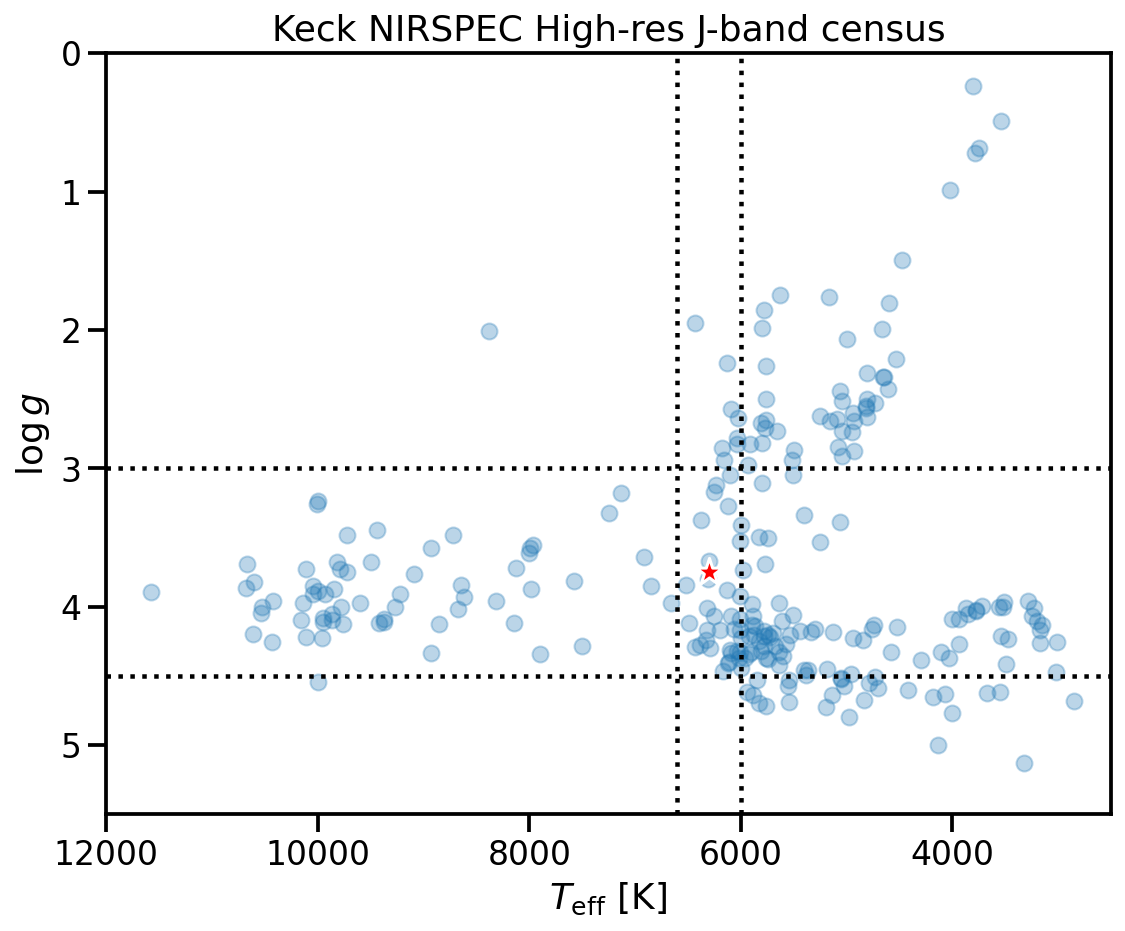

In [182]:
plt.figure(figsize=(9, 7))
plt.plot(df_log_dedupe['teff_gspphot'], df_log_dedupe['logg_gspphot'], 'o', alpha=0.3, ms=8)
plt.scatter(hat_p_67_GDR3['teff_gspphot'], hat_p_67_GDR3['logg_gspphot'], marker='*', 
            c='r', s=200, ec='w', zorder=10, label='HAT-P-67')
plt.xlim(12000, 2500)
plt.ylim(5.5, 0)

plt.axvline(6000, color='k', linestyle='dotted')
plt.axvline(6600, color='k', linestyle='dotted')

plt.axhline(3.0, color='k', linestyle='dotted')
plt.axhline(4.5, color='k', linestyle='dotted')

plt.xlabel('$T_\mathrm{eff}$ [K]')
plt.ylabel('$\log{g}$')
plt.title('Keck NIRSPEC High-res J-band census');

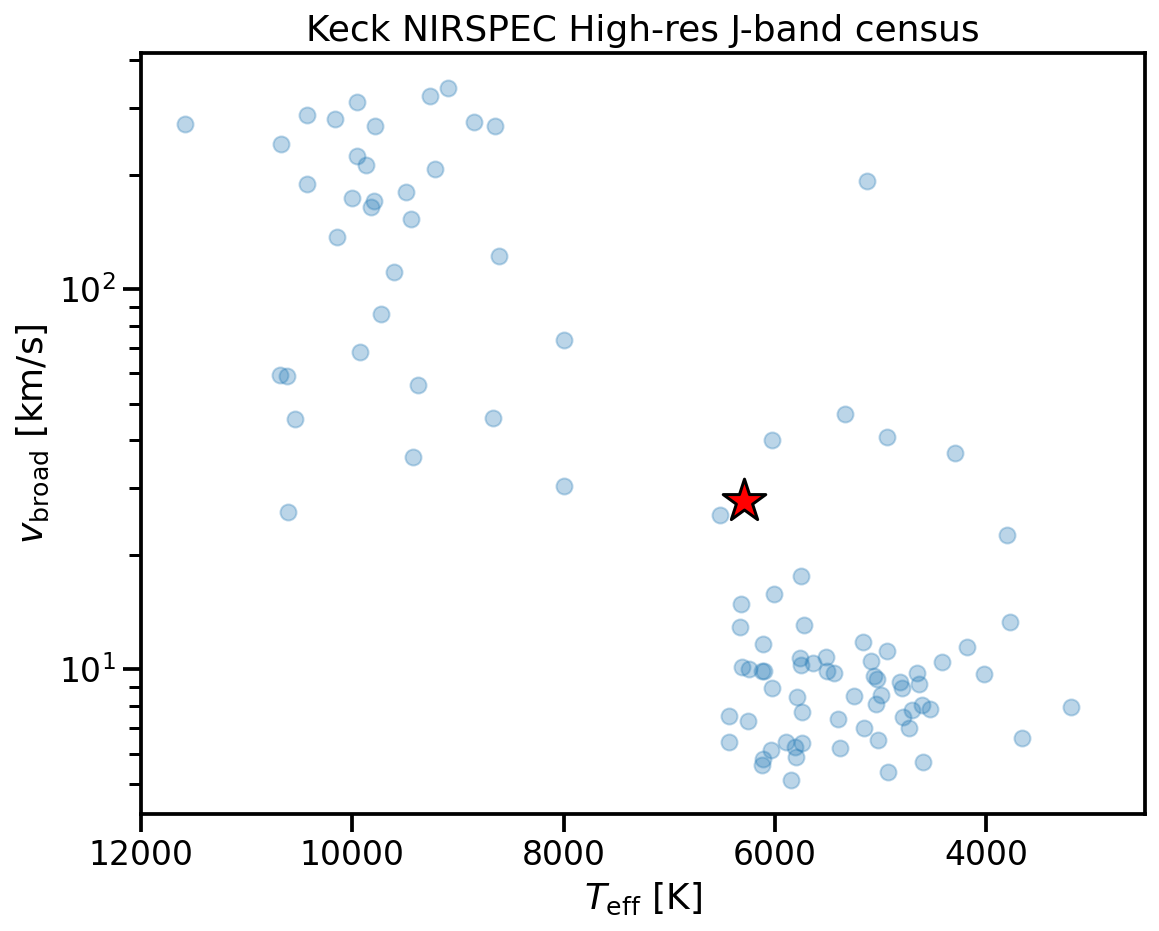

In [177]:
plt.figure(figsize=(9, 7))
plt.plot(df_log_dedupe['teff_gspphot'], df_log_dedupe['vbroad'], 'o', alpha=0.3, ms=8)
plt.scatter(hat_p_67_GDR3['teff_gspphot'], hat_p_67_GDR3['vbroad'], marker='*', 
            c='r', s=500, ec='k', zorder=10, label='HAT-P-67')
plt.xlim(12000, 2500)
plt.yscale('log')
plt.xlabel('$T_\mathrm{eff}$ [K]')
plt.ylabel('$v_\mathrm{broad}$ [km/s]')
plt.title('Keck NIRSPEC High-res J-band census');

## Select a comparison sample with Keck NIRSPEC data available

- $6300 <T_\mathrm{eff} [K] < 6500 $
- $3.5 < \log{g} < 4.5$

In [196]:
mask = ((df_log_dedupe.teff_gspphot > 6000) & 
        (df_log_dedupe.teff_gspphot < 6500) & 
        (df_log_dedupe.logg_gspphot > 3.0)  &
        (df_log_dedupe.logg_gspphot < 4.5)  )
df_comparison = df_log_dedupe[mask].reset_index()

Some of these are misclassified in Gaia DR3 (not a surprise)

In [ ]:
from astroquery.simbad import Simbad

In [198]:
Simbad.add_votable_fields('sptype', 'otype', 'rv_value')

In [199]:
#Simbad.list_votable_fields()

In [195]:
result_table = Simbad.query_object("Gaia DR3 1244571953471006720")
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SP_TYPE,SP_QUAL,SP_BIBCODE,OTYPE,RV_VALUE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,km / s,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,str1,object,object,float64,int32
* tau Boo,13 47 15.7381,+17 27 24.809,14,14,0.069,0.064,90,A,O,2020yCat.1350....0G,F7IV-V,C,2001AJ....121.2148G,RotV*,-16.030,1


In [202]:
df_comparison['MAIN_ID'] = ''
df_comparison['SP_TYPE'] = ''
df_comparison['OTYPE'] = ''

In [201]:
result_table[0]['MAIN_ID']

'* tau Boo'

In [205]:
for i in trange(len(df_comparison)):
    source_name = df_comparison.loc[i, 'DESIGNATION']
    result_table = Simbad.query_object(source_name)
    if result_table is not None:
        if len(result_table)>0:
            df_comparison.loc[i, 'MAIN_ID'] = result_table[0]['MAIN_ID']
            df_comparison.loc[i, 'SP_TYPE'] = result_table[0]['SP_TYPE']
            df_comparison.loc[i, 'OTYPE'] = result_table[0]['OTYPE']

  0%|          | 0/32 [00:00<?, ?it/s]

/Users/mag3842/miniforge3/envs/disperse_env/lib/python3.8/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR3 2779669097003726336
  warnings.warn("Warning: The script line number %i raised "


In [208]:
downselection = df_comparison.SP_TYPE.str.contains('F')

In [209]:
downselection.sum()

16

In [229]:
subset_cols = ['DESIGNATION', 'targname', 'MAIN_ID', 'SP_TYPE', 'OTYPE', 'date_obs', 
               'instrument', 'radial_velocity', 'vbroad']

In [230]:
df_comparison[downselection][subset_cols].reset_index(drop=True)

,DESIGNATION,targname,MAIN_ID,SP_TYPE,OTYPE,date_obs,instrument,radial_velocity,vbroad
0,Gaia DR3 1244571953471006720,Tau Boo,* tau Boo,F7IV-V,RotV*,[2021-01-07],43,-16.750475,14.836444
1,Gaia DR3 3208963374730670592,Par21,Parenago 21,F8,Star,[2010-07-16],11,27.214169,7.288233
2,Gaia DR3 4458990005388621952,BD+11 2998,BD+11 2998,F8,HorBranch*,[2005-05-19],6,NaN,NaN
3,Gaia DR3 4164893700353983104,HD 161770,HD 161770,F3V,HighPM*,[2005-05-19],4,-129.487289,5.585507
4,Gaia DR3 53848448829915776,HD 25532,HD 25532,F6IV-V,HorBranch*,[2009-11-22],4,-111.446838,9.899876
5,Gaia DR3 2427069874188580480,HD 3567,HD 3567,F7/8wF3,HighPM*,[2009-11-22],4,-47.030617,NaN
6,Gaia DR3 2178395219136276352,GM_Cep,V* GM Cep,F9,OrionV*,[2013-07-24],4,NaN,NaN
7,Gaia DR3 1891598193816300544,HR8430,* iot Peg,F5V,SB*,[2006-11-30],4,-6.941397,10.127225
8,Gaia DR3 1752459532807704704,HD 194598,HD 194598,F8,HighPM*,[2009-11-23],4,-246.787552,NaN
9,Gaia DR3 6199395656645838976,HD 135344B,CPD-36 6759,F8V,YSO,[2012-05-05],4,-5.341579,NaN


In [220]:
df_orig = df_NIRSPEC_raw[df_NIRSPEC_raw.targname.isin(df_comparison[downselection].targname.unique())]

In [232]:
df_orig.slitname.value_counts()

0.432x12    100
Name: slitname, dtype: int64

In [223]:
df_orig.progtitl.value_counts()

Probing Mass Loss from Two Mini-Neptunes Orbiting a Young Solar Analogue    43
Winds from Metal-Poor Population II Stars                                   24
NIRSPEC Spectroscopy of Stellar Targets                                     11
Winds from Metal-Poor Population II Red Giants                              10
Simultaneity of Accretion and Outflow in Young Stars                         4
He I as a probe of accretion/ejection in young stars                         4
Name: progtitl, dtype: int64

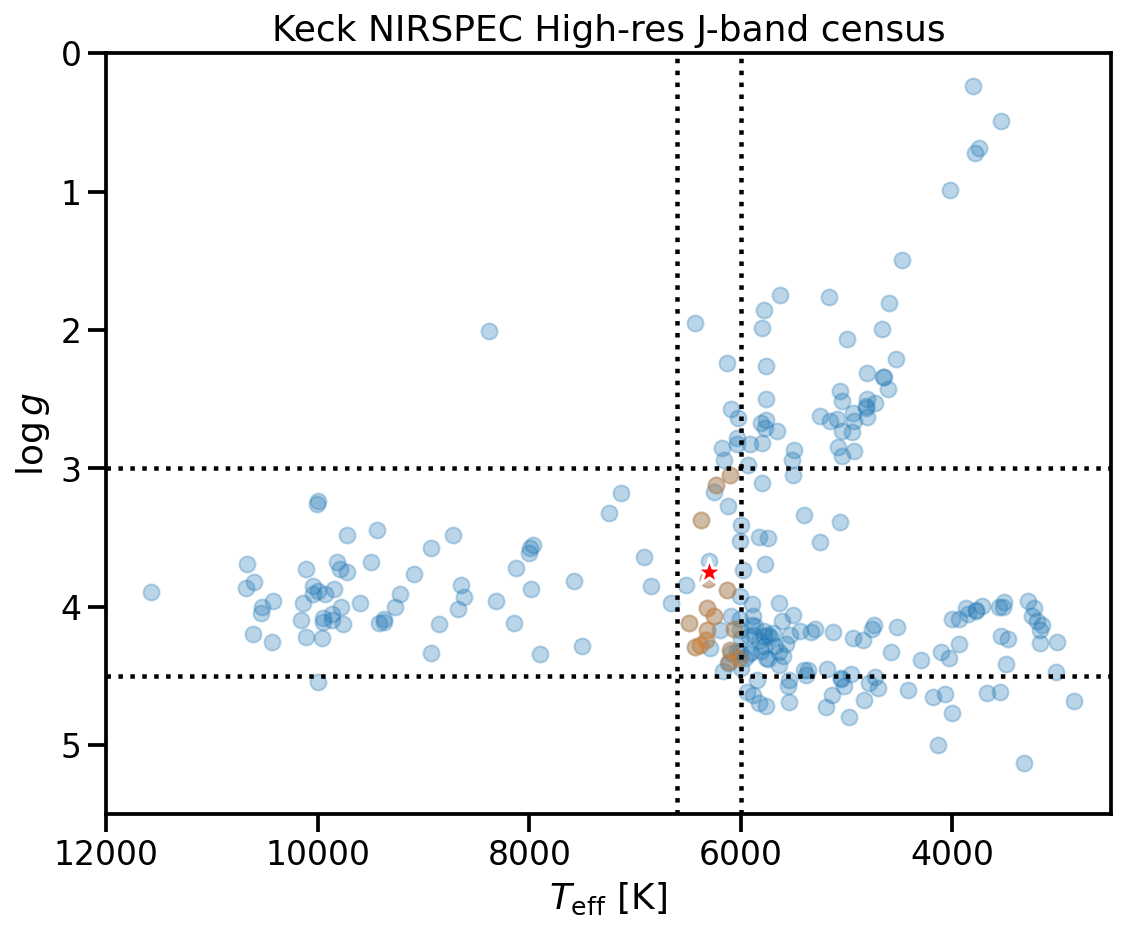

In [212]:
plt.figure(figsize=(9, 7))
plt.plot(df_log_dedupe['teff_gspphot'], df_log_dedupe['logg_gspphot'], 'o', alpha=0.3, ms=8)
plt.plot(df_comparison[downselection]['teff_gspphot'], df_comparison[downselection]['logg_gspphot'], 'o', alpha=0.3, ms=8)
plt.scatter(hat_p_67_GDR3['teff_gspphot'], hat_p_67_GDR3['logg_gspphot'], marker='*', 
            c='r', s=200, ec='w', zorder=10, label='HAT-P-67')
plt.xlim(12000, 2500)
plt.ylim(5.5, 0)

plt.axvline(6000, color='k', linestyle='dotted')
plt.axvline(6600, color='k', linestyle='dotted')

plt.axhline(3.0, color='k', linestyle='dotted')
plt.axhline(4.5, color='k', linestyle='dotted')

plt.xlabel('$T_\mathrm{eff}$ [K]')
plt.ylabel('$\log{g}$')
plt.title('Keck NIRSPEC High-res J-band census');